In [1]:
import math, random

import gym
import numpy as np
import tqdm
import torch
import tqdm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [3]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [4]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Cart Pole Environment</h2>

In [5]:
env_id = "CartPole-v0"
env = gym.make(env_id)

<h2>Epsilon greedy exploration</h2>

In [6]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # YOUR CODE HERE:  determine the `a` and `b` parameters such that the schedule is correct
        self.a = self.value_from
        self.b = np.log(self.a/self.value_to)/ (self.num_steps-1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }
        
        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """
        
        # YOUR CODE HERE:  implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        #value = ...
        
        if step <= 0:
            value = self.value_from
            return value
        
        if step >= self.num_steps - 1:
            value = self.value_to
            return value
        
        value = self.a/np.exp(self.b*step)
        return value

<h2>Double Deep Q Network</h2>

In [7]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            #state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            with torch.no_grad():
                state = Variable(torch.FloatTensor(state).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [8]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

<h3>Synchronize current policy net and target net</h3>

In [9]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [10]:
update_target(current_model, target_model)

<h2>Computing Temporal Difference Loss</h2>

In [11]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

<p><hr></p>

<h1>Atari Environment</h1>

In [13]:
from wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [14]:
env_id = "BreakoutNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [15]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            #state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            with torch.no_grad():
                state = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [16]:
current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

update_target(current_model, target_model)

In [18]:
num_frames = 2_000_000
batch_size = 32
gamma      = 0.99
losses = []
returns = []
lengths = []
episode_reward = []
t_episode = 0
i_episode = 0
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)

state = env.reset()
pbar = tqdm.tnrange(num_frames, ncols='100%')


for frame_idx in pbar:
    epsilon = exploration.value(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        G = 0
        for i in reversed(episode_reward):
            G = i + G * gamma
        returns.append(G)
        episode_reward = []
        pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {epsilon:4.2f}'
            )
        lengths.append(t_episode+1)
        t_episode = 0
        i_episode += 1
    else:
        t_episode += 1
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        #losses.append(loss.data[0])
        losses.append(loss.item())

    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)
        

In [20]:
def plot(frame_idx, returns, lengths, losses):
    clear_output(True)
    # YOUR PLOTS HERE
    epochs = np.arange(len(returns))
    # smooth data
    smoothed_returns = rolling_average(returns, window_size = 100)
    smoothed_lengths = rolling_average(lengths, window_size = 100)
    smoothed_losses = rolling_average(losses, window_size = 100)
    # plot the returns
    fig = plt.figure(figsize=(14, 10))
    ax1 = fig.add_subplot(311)
    line_1, = ax1.plot(epochs, returns, 'salmon', linewidth=2.0)
    line_2, = ax1.plot(epochs, smoothed_returns, 'r', linewidth=2.0)
    plt.xlabel('Number of episodes')
    plt.ylabel('Averaged returns')
    plt.title('Returns')
    plt.legend((line_1, line_2), ('raw', 'smoothed'))
    ax2 = fig.add_subplot(312)
    line_1, = ax2.plot(epochs, lengths, 'lightblue', linewidth=2.0)
    line_2, = ax2.plot(epochs, smoothed_lengths, 'b', linewidth=2.0)
    plt.xlabel('Number of episodes')
    plt.ylabel('Averaged lengths')
    plt.title('Lengths')
    plt.legend((line_1, line_2), ('raw', 'smoothed'))
    ax3 = fig.add_subplot(313)
    epochs = np.arange(len(losses))
    line_1, = ax3.plot(epochs, losses, 'lightgreen', linewidth=2.0)
    line_2, = ax3.plot(epochs, smoothed_losses, 'g', linewidth=2.0)
    plt.xlabel('Number of time step')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend((line_1, line_2), ('raw', 'smoothed'))
    plt.show()
#     plt.figure(figsize=(100,25))
#     plt.subplot(131)
#     plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
#     plt.plot(returns)
#     plt.subplot(132)
#     plt.title('loss')
#     plt.plot(losses)
#     plt.show()

In [21]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
#     assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

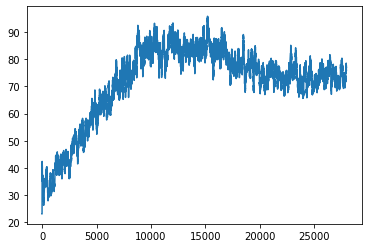

In [26]:
plt.plot(rolling_average(lengths, window_size = 100))

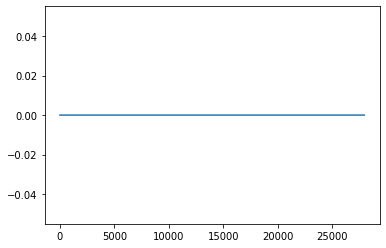

In [25]:
plt.plot(rolling_average(returns, window_size = 100))

In [19]:
a1 = np.array(lengths)
b1 = np.array(returns)

df = pd.DataFrame({"lengths" : a1, "returns" : b1})
df.to_csv("breakout_double_dqn.csv", index=False)